In [1]:
import torch
from modelscope import AutoModel

In [ ]:
MODEL_NAME= "/home/public/dkx/model/BAAI/BGE-VL-v1.5-zs"

model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
model.eval()
model.cuda()

In [12]:
with torch.no_grad():
    model.set_processor(MODEL_NAME)

    # query_inputs = model.data_process(
    #     text="Make the background dark, as if the camera has taken the photo at night",
    #     images="./assets/cir_query.png",
    #     q_or_c="q",
    #     task_instruction="Retrieve the target image that best meets the combined criteria by using both the provided image and the image retrieval instructions: "
    # )

    candidate_inputs = model.data_process(
        text="",
        images=[""],
        q_or_c="c",
    )

    # query_embs = model(**query_inputs, output_hidden_states=True)[:, -1, :]
    candi_embs = model(**candidate_inputs, output_hidden_states=True)[:, -1, :]

    # query_embs = torch.nn.functional.normalize(query_embs, dim=-1)
    candi_embs = torch.nn.functional.normalize(candi_embs, dim=-1)

    # scores = torch.matmul(query_embs, candi_embs.T)
print(candi_embs.shape)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
import torch.nn.functional as F
from torch import Tensor
from modelscope import AutoTokenizer

In [2]:
def last_token_pool(last_hidden_states: Tensor,
                        attention_mask: Tensor) -> Tensor:
        left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
        if left_padding:
            return last_hidden_states[:, -1]
        else:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            batch_size = last_hidden_states.shape[0]
            return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'

# Each query must come with a one-sentence instruction that describes the task
task = 'Given a piece of text, recommend the most suitable type of chart to visualize it.'

queries = [
    get_detailed_instruct(task, 'What is the capital of China?'),
    get_detailed_instruct(task, 'Explain gravity')
]
# No need to add instruction for retrieval documents
documents = [
        "The capital of China is Beijing.",
        "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
]

input_texts = queries + documents
tokenizer = AutoTokenizer.from_pretrained('/home/public/dkx/model/Qwen/Qwen3-Embedding-8', padding_side='left')
model = AutoModel.from_pretrained('/home/public/dkx/model/Qwen/Qwen3-Embedding-8')
# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-8B', attn_implementation="flash_attention_2", torch_dtype=torch.float16).cuda()
# Tokenize the input texts
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=8192,
    return_tensors="pt",
)
batch_dict.to(model.device)
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)

torch.Size([2880, 4096])


In [ ]:
scores = (embeddings[:2] @ embeddings[2:].T)

In [2]:
from PIL import Image
from modelscope import AutoProcessor

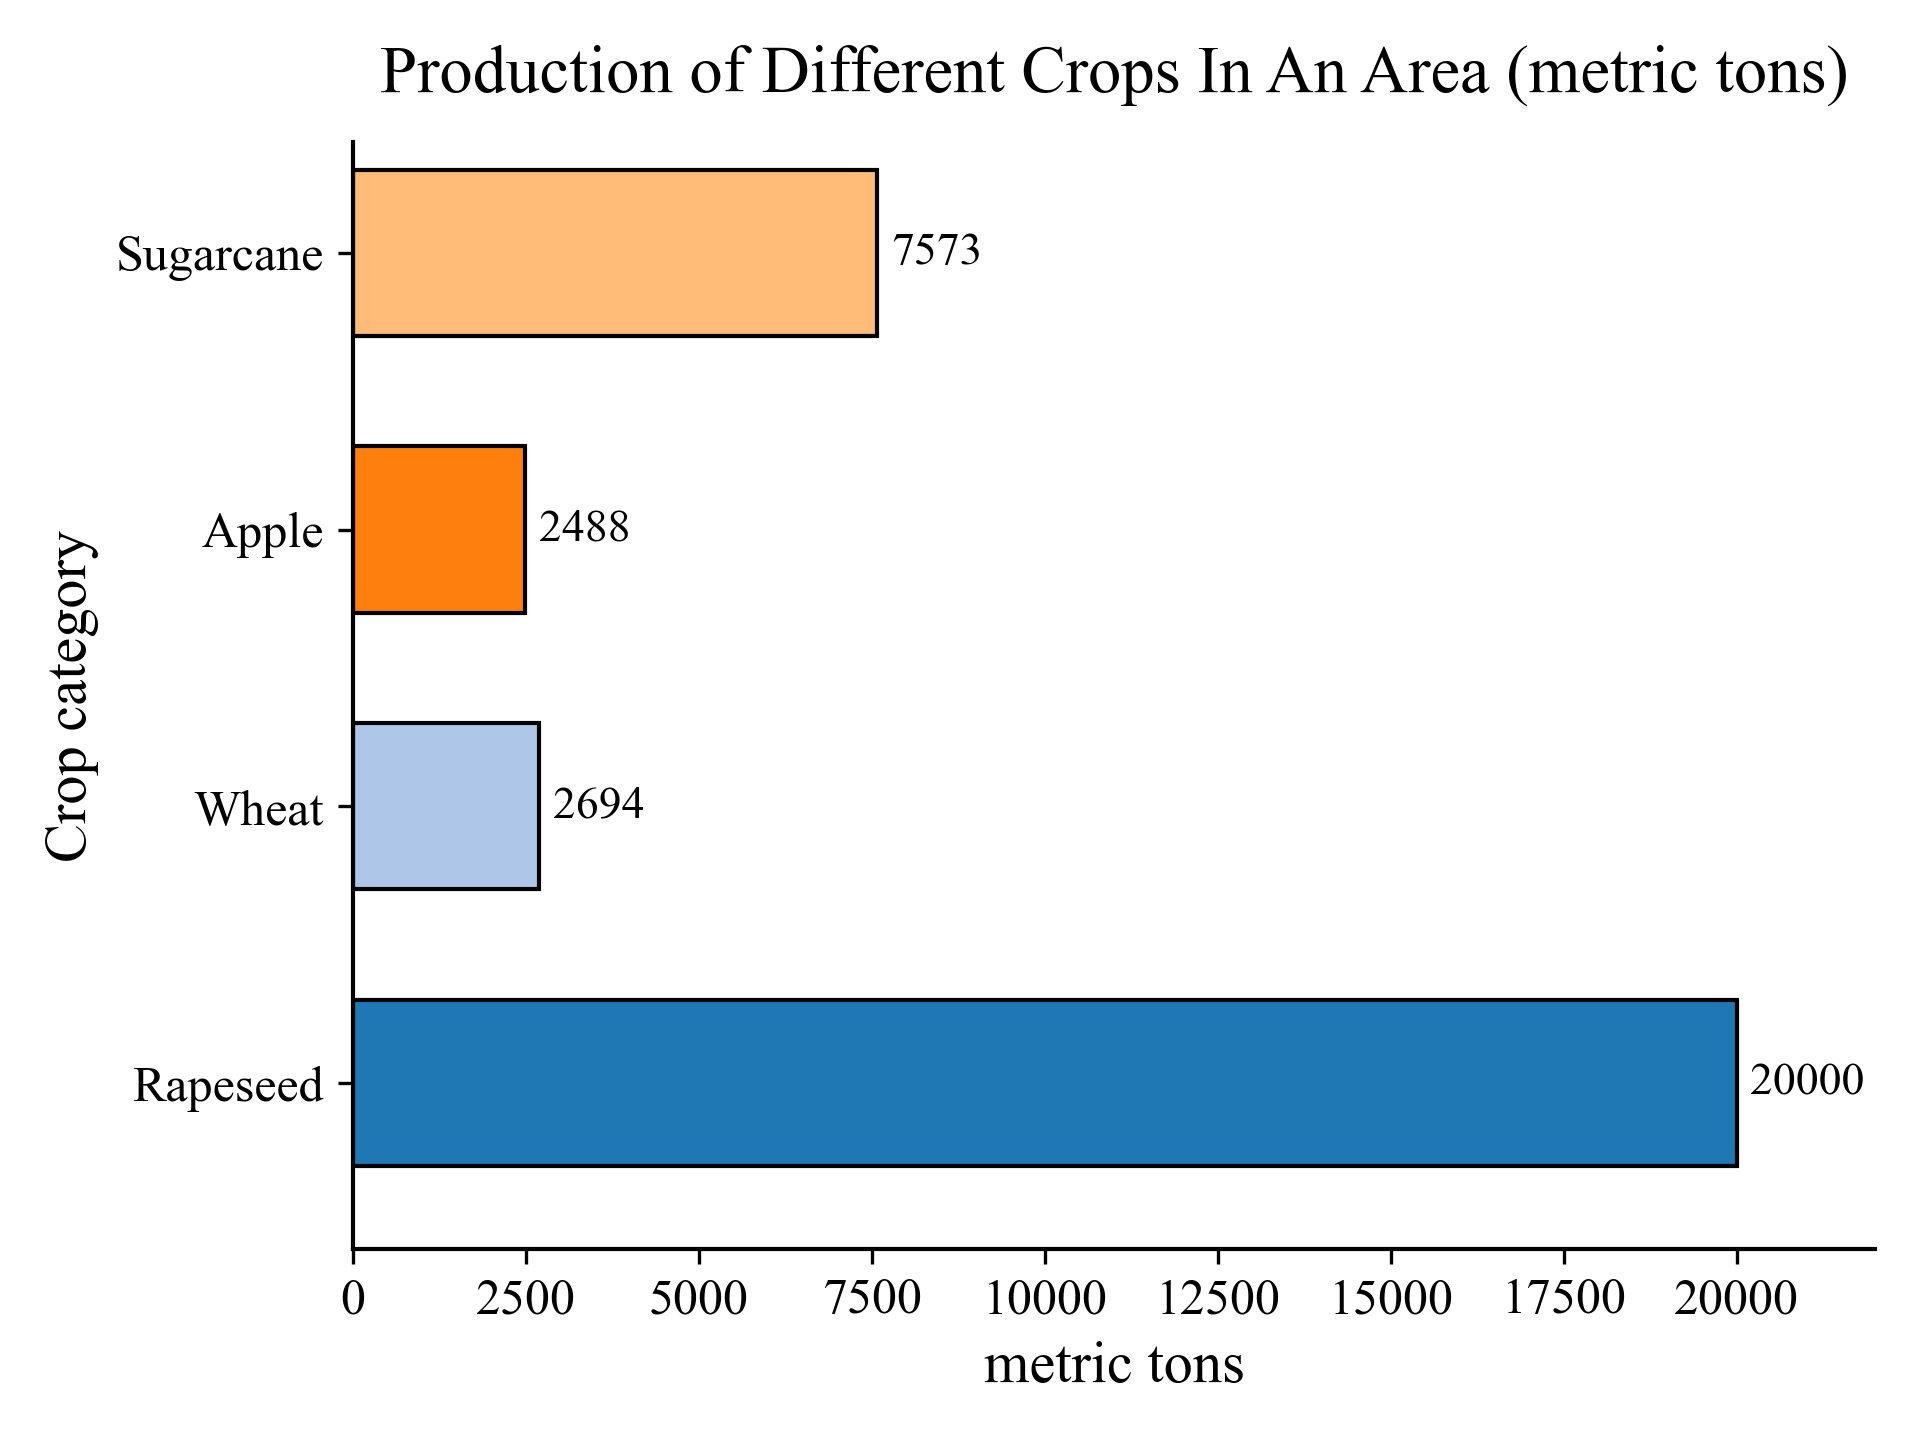

In [14]:
image = Image.open("/home/dukaixing/RAG4Ghart/Dataset-ZXQ/sample100/bar/png/21.png").convert('RGB')

display(image)

In [3]:
model = AutoModel.from_pretrained("/home/public/dkx/model/fancyfeast/so400m-long", torch_dtype=torch.float32, device_map="auto", attn_implementation="sdpa")
processor = AutoProcessor.from_pretrained("/home/public/dkx/model/fancyfeast/so400m-long")

images = [
    Image.open("/home/dukaixing/RAG4Ghart/Dataset-ZXQ/sample100/bar/png/21.png").convert('RGB'),
    Image.open("/home/dukaixing/RAG4Ghart/Dataset-ZXQ/sample100/line/png/3.png").convert('RGB'),
]

texts = ["a bar chart", "a line chart"]
inputs = processor(text=texts, images=images, padding="max_length", max_length=256, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

dir(outputs)

/home/dukaixing/RAG4Ghart/.venv/lib/python3.12/site-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['logit_scale', 'logit_bias']
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'image_embeds',
 'items',
 'keys',
 'logits_per_image',
 'logits_per_text',
 'loss',
 'move_to_end',
 'pop',
 'popitem',
 'setdefault',
 'text_embeds',
 'text_model_output',
 'to_tuple',
 'update',
 'values',
 'vision_model_output']

In [6]:
outputs.image_embeds.shape

torch.Size([2, 1152])